In [1]:
from Sub_Functions.MultiLayerNet import *
from Sub_Functions.InternalEnergy import *
from Sub_Functions.IntegrationFext import *
from torch.autograd import grad

import numpy as np
import time
import torch
import matplotlib.pyplot as plt
import numpy.random as npr
import pandas as pd
import random
import os

In [2]:
npr.seed(2019)
torch.manual_seed(2019)

In [3]:
def load_best_model(model, filename):
    model.load_state_dict(torch.load(filename, map_location=torch.device('cpu')))
    return model

In [4]:
#------------------------- Constant Network Parameters ----------------
D_in = 2
D_out = 2

In [5]:
# -------------------------- Structural Parameters ---------------------
Length = 4
Height = 1
Depth = 1.0

In [6]:
# -------------------------- Boundary Conditions ------------------------
known_left_ux = 0
known_left_uy = 0
bc_left_penalty = 1.0

known_right_tx = 0
known_right_ty = -10
bc_right_penalty = 1.0

In [7]:
# -------------------------- Material Parameters -----------------------
model_energy = 'Elastic2D'
E = 1000
nu = 0.3

In [8]:
# ------------------------- Datapoints for training ---------------------
Nx = 100
Ny = 25
x_min, y_min = (0.0, 0.0)
hx = Length / (Nx - 1)
hy = Height / (Ny - 1)
shape = [Nx, Ny]
dxdy = [hx, hy]

In [9]:
# ------------------------- Datapoints for evaluation -----------------
Length_test = 4
Height_test = 1
num_test_x = 201
num_test_y = 100
hx_test = Length / (num_test_x - 1)
hy_test = Height / (num_test_y - 1)
shape_test = [num_test_x, num_test_y]

In [10]:
dev = torch.device('cpu')
if torch.cuda.is_available():
    print("CUDA is available, running on GPU")
    dev = torch.device('cuda')
    device_string = 'cuda'
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
else:
    device_string = 'cpu'
    print("CUDA not available, running on CPU")
    torch.set_default_tensor_type('torch.DoubleTensor')

plt.rcParams['figure.dpi'] = 350

CUDA not available, running on CPU


In [11]:
def get_Train_domain():
    x_dom = x_min, Length, Nx
    y_dom = y_min, Height, Ny
    lin_x = np.linspace(x_dom[0], x_dom[1], x_dom[2])
    lin_y = np.linspace(y_dom[0], y_dom[1], y_dom[2])
    dom = np.zeros((Nx * Ny, 2))
    c = 0
    node_dy = (y_dom[1] - y_dom[0]) / (y_dom[2] - 1)
    node_dx = (x_dom[1] - x_dom[0]) / (x_dom[2] - 1)
    for x in np.nditer(lin_x):
        tb = y_dom[2] * c
        te = tb + y_dom[2]
        c += 1
        dom[tb:te, 0] = x
        dom[tb:te, 1] = lin_y

    bcl_u_pts_idx = np.where(dom[:, 0] == x_min)
    bcl_u_pts = dom[bcl_u_pts_idx, :][0]
    bcl_u = np.ones(np.shape(bcl_u_pts)) * [known_left_ux, known_left_uy]

    bcr_t_pts_idx = np.where(dom[:, 0] == Length)
    bcr_t_pts = dom[bcr_t_pts_idx, :][0]
    bcr_t = np.ones(np.shape(bcr_t_pts)) * [known_right_tx, known_right_ty]

    boundary_neumann = {
        "neumann_1": {
            "coord": bcr_t_pts,
            "known_value": bcr_t,
            "penalty": bc_right_penalty,
            "idx": np.asarray(bcr_t_pts_idx)
        }
    }

    boundary_dirichlet = {
        "dirichlet_1": {
            "coord": bcl_u_pts,
            "known_value": bcl_u,
            "penalty": bc_left_penalty,
            "idx": np.asarray(bcl_u_pts_idx)
        }
    }

    bcr_t_pts_idx_new = np.where((dom[:, 0] == Length) & (dom[:, 1] > 0.75))
    bcr_t_pts_new = dom[bcr_t_pts_idx_new, :][0]
    bcr_t_new = np.ones(np.shape(bcr_t_pts_new)) * [known_right_tx, known_right_ty]

    boundary_neumann_new = {
        "neumann_1": {
            "coord": bcr_t_pts_new,
            "known_value": bcr_t_new,
            "penalty": bc_right_penalty,
            "idx": np.asarray(bcr_t_pts_idx_new)
        }
    }

    dom = torch.from_numpy(dom).float()  # Cast to float

    return dom, boundary_neumann, boundary_dirichlet

In [12]:
def get_Test_datatest(Nx=num_test_x, Ny=num_test_y):
    x_dom_test = x_min, Length_test, Nx
    y_dom_test = y_min, Height_test, Ny
    x_space = np.linspace(x_dom_test[0], x_dom_test[1], x_dom_test[2])
    y_space = np.linspace(y_dom_test[0], y_dom_test[1], y_dom_test[2])
    xGrid, yGrid = np.meshgrid(x_space, y_space)
    data_test = np.concatenate(
        (np.array([xGrid.flatten()]).T, np.array([yGrid.flatten()]).T), axis=1)
    return x_space, y_space, data_test

In [13]:
def get_density():
    density = torch.ones(Ny-1, Nx-1)
    train_x_coord = np.transpose(dom[:, 0].reshape(Nx, Ny))
    train_y_coord = np.transpose(dom[:, 1].reshape(Nx, Ny))

    Crcl_x = Length / 2
    Crcl_y = Height / 2
    E_major = 0.25
    E_minor = 0.25

    for nodex in range(Nx):
        for nodey in range(Ny):
            if (((train_x_coord[nodey, nodex] - Crcl_x) / E_major) ** 2 + ((train_y_coord[nodey, nodex] - Crcl_y) / E_minor) ** 2 < 1):
                density[nodey, nodex] = 0

In [14]:
class DeepEnergyMethod:
    def __init__(self, model, dim, E, nu, act_func, CNN_dev, rff_dev, N_Layers):
        self.model = MultiLayerNet(model[0], model[1], model[2], act_func, CNN_dev, rff_dev, N_Layers)
        self.model = self.model.to(dev)
        self.InternalEnergy = InternalEnergy(E, nu)
        self.FextLoss = IntegrationFext(dim)
        self.dim = dim
        self.lossArray = []

    def train_model(self, shape, dxdydz, data, neumannBC, dirichletBC, iteration, learning_rate, N_Layers, activatn_fn, density):
        x = data.double().to(dev)  # Ensure data is double
        x.requires_grad_(True)

        dirBC_coordinates = {}
        dirBC_values = {}
        dirBC_penalty = {}
        for i, keyi in enumerate(dirichletBC):
            dirBC_coordinates[i] = torch.from_numpy(dirichletBC[keyi]['coord']).double().to(dev)
            dirBC_values[i] = torch.from_numpy(dirichletBC[keyi]['known_value']).double().to(dev)
            dirBC_penalty[i] = torch.tensor(dirichletBC[keyi]['penalty']).double().to(dev)

        neuBC_coordinates = {}
        neuBC_values = {}
        neuBC_penalty = {}
        neuBC_idx = {}
        for i, keyi in enumerate(neumannBC):
            neuBC_coordinates[i] = torch.from_numpy(neumannBC[keyi]['coord']).double().to(dev)
            neuBC_coordinates[i].requires_grad_(True)
            neuBC_values[i] = torch.from_numpy(neumannBC[keyi]['known_value']).double().to(dev)
            neuBC_penalty[i] = torch.tensor(neumannBC[keyi]['penalty']).double().to(dev)
            neuBC_idx[i] = torch.from_numpy(neumannBC[keyi]['idx']).double().to(dev)

        optimizer_LBFGS = torch.optim.LBFGS(self.model.parameters(), lr=learning_rate, max_iter=20, line_search_fn='strong_wolfe')
        start_time = time.time()
        loss_history = np.zeros(iteration)

        for t in range(iteration):
            def closure():
                u_pred = self.getU(x, N_Layers, activatn_fn)
                storedEnergy = self.InternalEnergy.Elastic2DGauusQuad(u_pred, x, dxdydz, shape, density)
                externalE = self.FextLoss.lossFextEnergy(u_pred, x, neuBC_coordinates, neuBC_values, neuBC_idx, dxdydz)
                energy_loss = storedEnergy - externalE

                bc_u_crit = torch.zeros((len(dirBC_coordinates)))
                for i, vali in enumerate(dirBC_coordinates):
                    dir_u_pred = self.getU(dirBC_coordinates[i], N_Layers, activatn_fn)
                    bc_u_crit[i] = self.loss_squared_sum(dir_u_pred, dirBC_values[i])

                boundary_loss = torch.sum(bc_u_crit)
                loss = energy_loss + boundary_loss
                optimizer_LBFGS.zero_grad()
                loss.backward()
                loss_history[t] = loss.item()
                self.lossArray.append(loss.data)
                return loss

            if t > 0 and (np.abs(loss_history[t - 1] - loss_history[t - 2]) < 10e-5):
                break

            optimizer_LBFGS.step(closure)
        elapsed = time.time() - start_time
        return loss_history[:t]

    def getU(self, x, N_Layers, activatn_fn):
        u = self.model(x.double(), N_Layers, activatn_fn).double()  # Ensure x is double
        Ux = x[:, 0] * u[:, 0]
        Uy = x[:, 0] * u[:, 1]
        Ux = Ux.reshape(Ux.shape[0], 1)
        Uy = Uy.reshape(Uy.shape[0], 1)
        u_pred = torch.cat((Ux, Uy), -1)
        return u_pred

    @staticmethod
    def loss_squared_sum(tinput, target):
        row, column = tinput.shape
        loss = 0
        for j in range(column):
            loss += torch.sum((tinput[:, j] - target[:, j]) ** 2) / tinput[:, j].data.nelement()
        return loss

In [15]:
def plot_comparison(Ux, Uy, shape_test, filename='comparison_plot'):
    # Load Abaqus results
    abaqus_res = pd.read_excel("/Users/abueidd2/Library/CloudStorage/Box-Box/Optimizing_hyperparameters_and_architecture_of_deep_energy_method/Cybershuttle/Abaqus_Displacements.xlsx", sheet_name="Bending")
    
    # Verify the shape of the Abaqus results
    print(abaqus_res.shape)

    # Adjust the shape parameters based on the actual data
    shape_ab = [201, 100]  # Adjust this based on actual data dimensions

    x_coords_ab = abaqus_res.X_orignal.to_numpy().reshape(shape_ab[1], shape_ab[0])
    y_coords_ab = abaqus_res.Y_orignal.to_numpy().reshape(shape_ab[1], shape_ab[0])

    Ux_ab = abaqus_res.U1.to_numpy().reshape(shape_ab[1], shape_ab[0])
    Uy_ab = abaqus_res.U2.to_numpy().reshape(shape_ab[1], shape_ab[0])

    Ux_ab = np.where(Ux_ab == 0, 10**(-8), Ux_ab)
    Uy_ab = np.where(Uy_ab == 0, 10**(-8), Uy_ab)

    x_new_coords_ab = abaqus_res.X_disp.to_numpy().reshape(shape_ab[1], shape_ab[0])
    y_new_coords_ab = abaqus_res.Y_disp.to_numpy().reshape(shape_ab[1], shape_ab[0])

    error_Ux = abs(Ux.reshape(shape_test[1], shape_test[0]) - Ux_ab)
    error_Uy = abs(Uy.reshape(shape_test[1], shape_test[0]) - Uy_ab)

    L2_Ux = np.power(error_Ux, 2)
    L2_Uy = np.power(error_Uy, 2)

    L2_norm = np.sqrt(sum(sum((L2_Ux + L2_Uy))) / (shape_ab[1] * shape_ab[0]))
    print('L2_norm= %0.8f' % (L2_norm))

    #----------------- Final Plot-------------------
    colorbar_ratio = 1
    fig, ax = plt.subplots(3, 2)
    fig.tight_layout()
    plt.setp(ax, xticks=[0, 1, 2, 3, 4], yticks=[0, 1])

    cp = ax[0][0].contourf(x_new_coords_ab.reshape(shape_test[1], shape_test[0]), y_new_coords_ab.reshape(shape_test[1], shape_test[0]),
                           Ux.reshape(shape_test[1], shape_test[0]), 12, cmap='jet')
    ax[0][0].set_title('DEM: $U_x$')
    ax[0][0].set_aspect('equal')
    fig.colorbar(cp, shrink=colorbar_ratio, location='left', ax=ax[0][0])

    cp2 = ax[0][1].contourf(x_new_coords_ab.reshape(shape_test[1], shape_test[0]), y_new_coords_ab.reshape(shape_test[1], shape_test[0]),
                            Uy.reshape(shape_test[1], shape_test[0]), 12, cmap='jet')
    ax[0][1].set_title('DEM: $U_y$')
    ax[0][1].set_aspect('equal')
    fig.colorbar(cp2, shrink=colorbar_ratio, location='left', ax=ax[0][1])

    cp = ax[1][0].contourf(x_new_coords_ab, y_new_coords_ab.reshape(shape_test[1], shape_test[0]),
                           Ux_ab.reshape(shape_test[1], shape_test[0]), 12, cmap='jet')
    ax[1][0].set_title('FEM: $U_x$')
    fig.colorbar(cp, shrink=colorbar_ratio, location='left', ax=ax[1][0])
    ax[1][0].set_aspect('equal')

    cp2 = ax[1][1].contourf(x_new_coords_ab.reshape(shape_test[1], shape_test[0]), y_new_coords_ab.reshape(shape_test[1], shape_test[0]),
                            Uy_ab.reshape(shape_test[1], shape_test[0]), 12, cmap='jet')
    ax[1][1].set_aspect('equal')
    ax[1][1].set_title('FEM: $U_y$')
    fig.colorbar(cp2, shrink=colorbar_ratio, location='left', ax=ax[1][1])

    cp = ax[2][0].contourf(x_new_coords_ab.reshape(shape_test[1], shape_test[0]), y_new_coords_ab.reshape(shape_test[1], shape_test[0]),
                           error_Ux, 12, cmap='jet')
    ax[2][0].set_title('$Error_x$ = |$U_{x(FEA)}$ - $U_{x(DEM)}$|', y=1.08)
    ax[2][0].set_aspect('equal')
    fig.colorbar(cp, shrink=colorbar_ratio, location='left', ax=ax[2][0])

    cp2 = ax[2][1].contourf(x_new_coords_ab.reshape(shape_test[1], shape_test[0]), y_new_coords_ab.reshape(shape_test[1], shape_test[0]),
                            error_Uy, 12, cmap='jet')
    ax[2][1].set_title('$Error_y$ = |$U_{y(FEA)}$ - $U_{y(DEM)}$|', y=1.08)
    ax[2][1].set_aspect('equal')
    fig.colorbar(cp2, shrink=colorbar_ratio, location='left', ax=ax[2][1])

    fig.dpi = 700
    fig.set_size_inches(6, 6)
    
    plt.show()

In [16]:
def main():
    # Load the best hyperparameters
    best_params = np.load('best_params.npy', allow_pickle=True).item()
    
    lr = best_params['lr']
    neuron = best_params['neuron']
    CNN_dev = best_params['CNN_dev']
    rff_dev = best_params['rff_dev']
    N_Layers = best_params['N_Layers']
    act_func = best_params['act_func']

    dom, boundary_neumann, boundary_dirichlet = get_Train_domain()
    x, y, datatest = get_Test_datatest()
    density = 1

    dem = DeepEnergyMethod([D_in, neuron, D_out], 2, E, nu, act_func, CNN_dev, rff_dev, N_Layers)
    
    # Load the best model
    dem.model = load_best_model(dem.model, 'best_model.pth')

    print('Loaded model with parameters:')
    print('lr: %.10e\t neuron: %.3d\t CNN_Sdev: %.10e\t RNN_Sdev: %.10e\t Layers: %d\t Act_fn: %s'
          % (lr, neuron, CNN_dev, rff_dev, N_Layers, act_func))

    # Load the loss history
    loss_history = np.load('best_loss_history.npy')

    # Plot the loss function
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(loss_history)), loss_history, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function Convergence')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Obtain displacements from the model
    u_pred = dem.getU(torch.from_numpy(datatest).float().to(dev), N_Layers, act_func)
    Ux = u_pred[:, 0].cpu().detach().numpy()
    Uy = u_pred[:, 1].cpu().detach().numpy()

    # Plot comparison with ground truth
    plot_comparison(Ux, Uy, shape_test, filename='best_model_comparison')

Loaded model with parameters:
lr: 1.5719633541e+00	 neuron: 040	 CNN_Sdev: 1.8854810347e-01	 RNN_Sdev: 4.3617079343e-01	 Layers: 10	 Act_fn: tanh


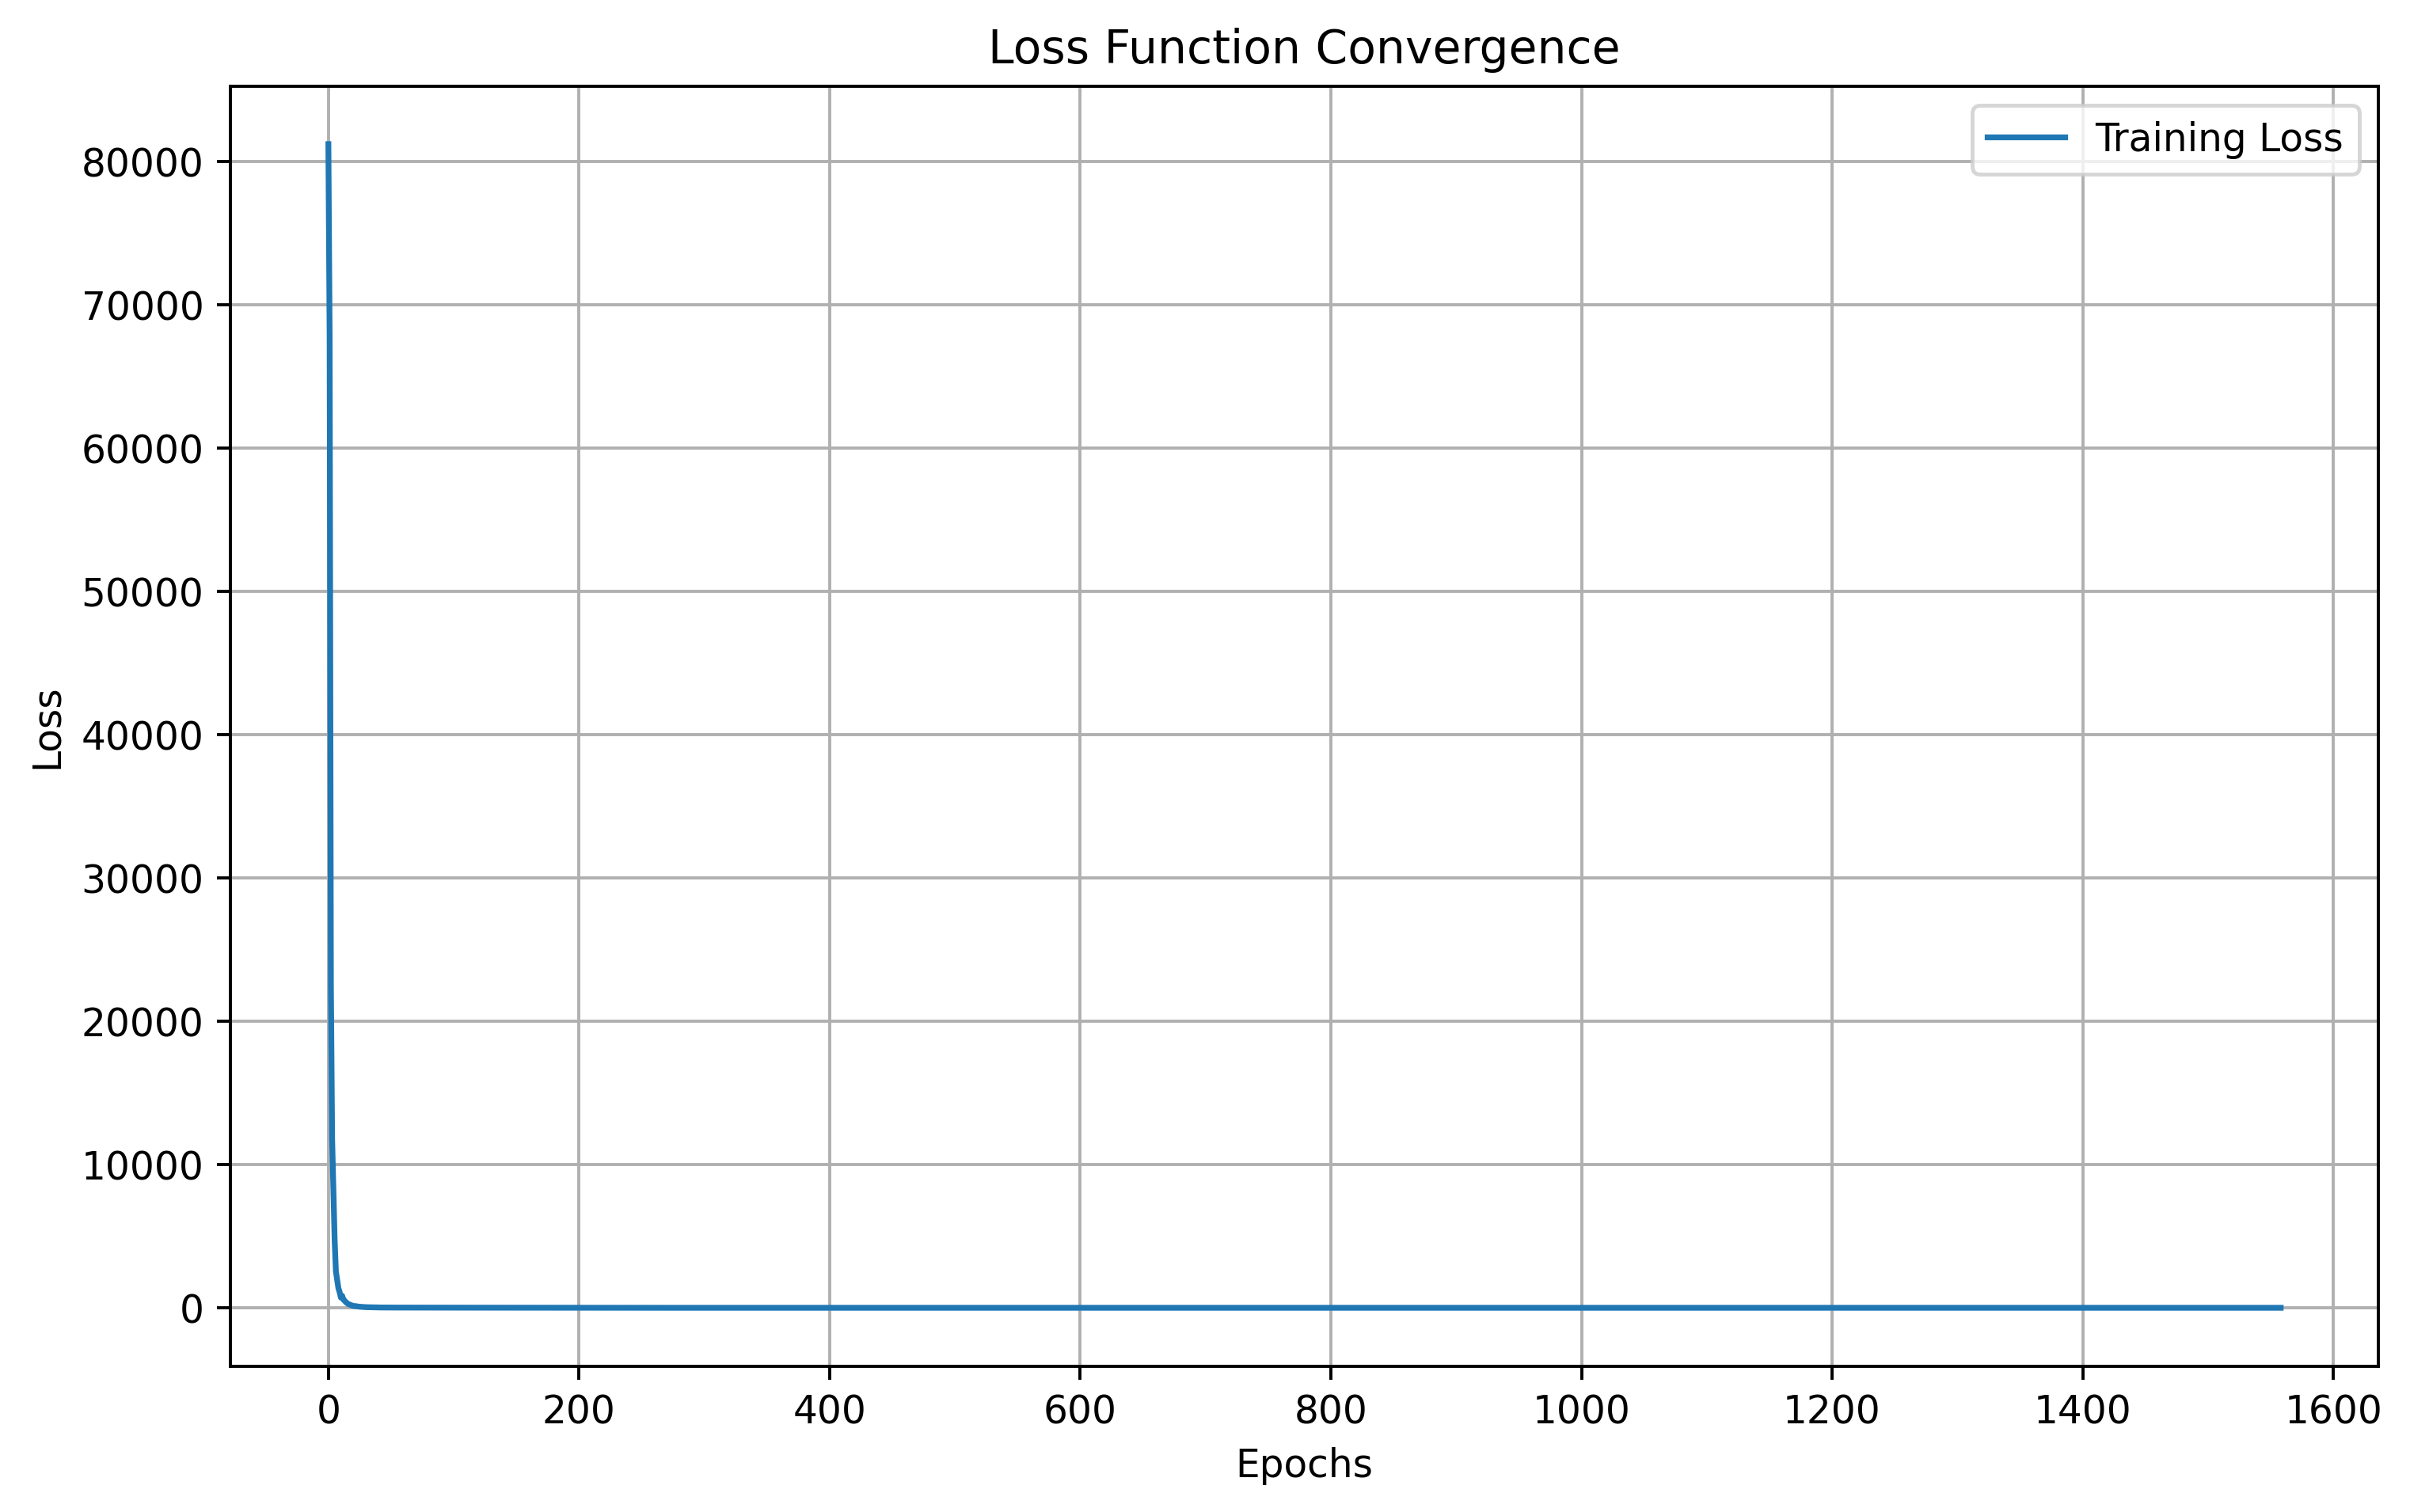

(20100, 9)
L2_norm= 0.00184858


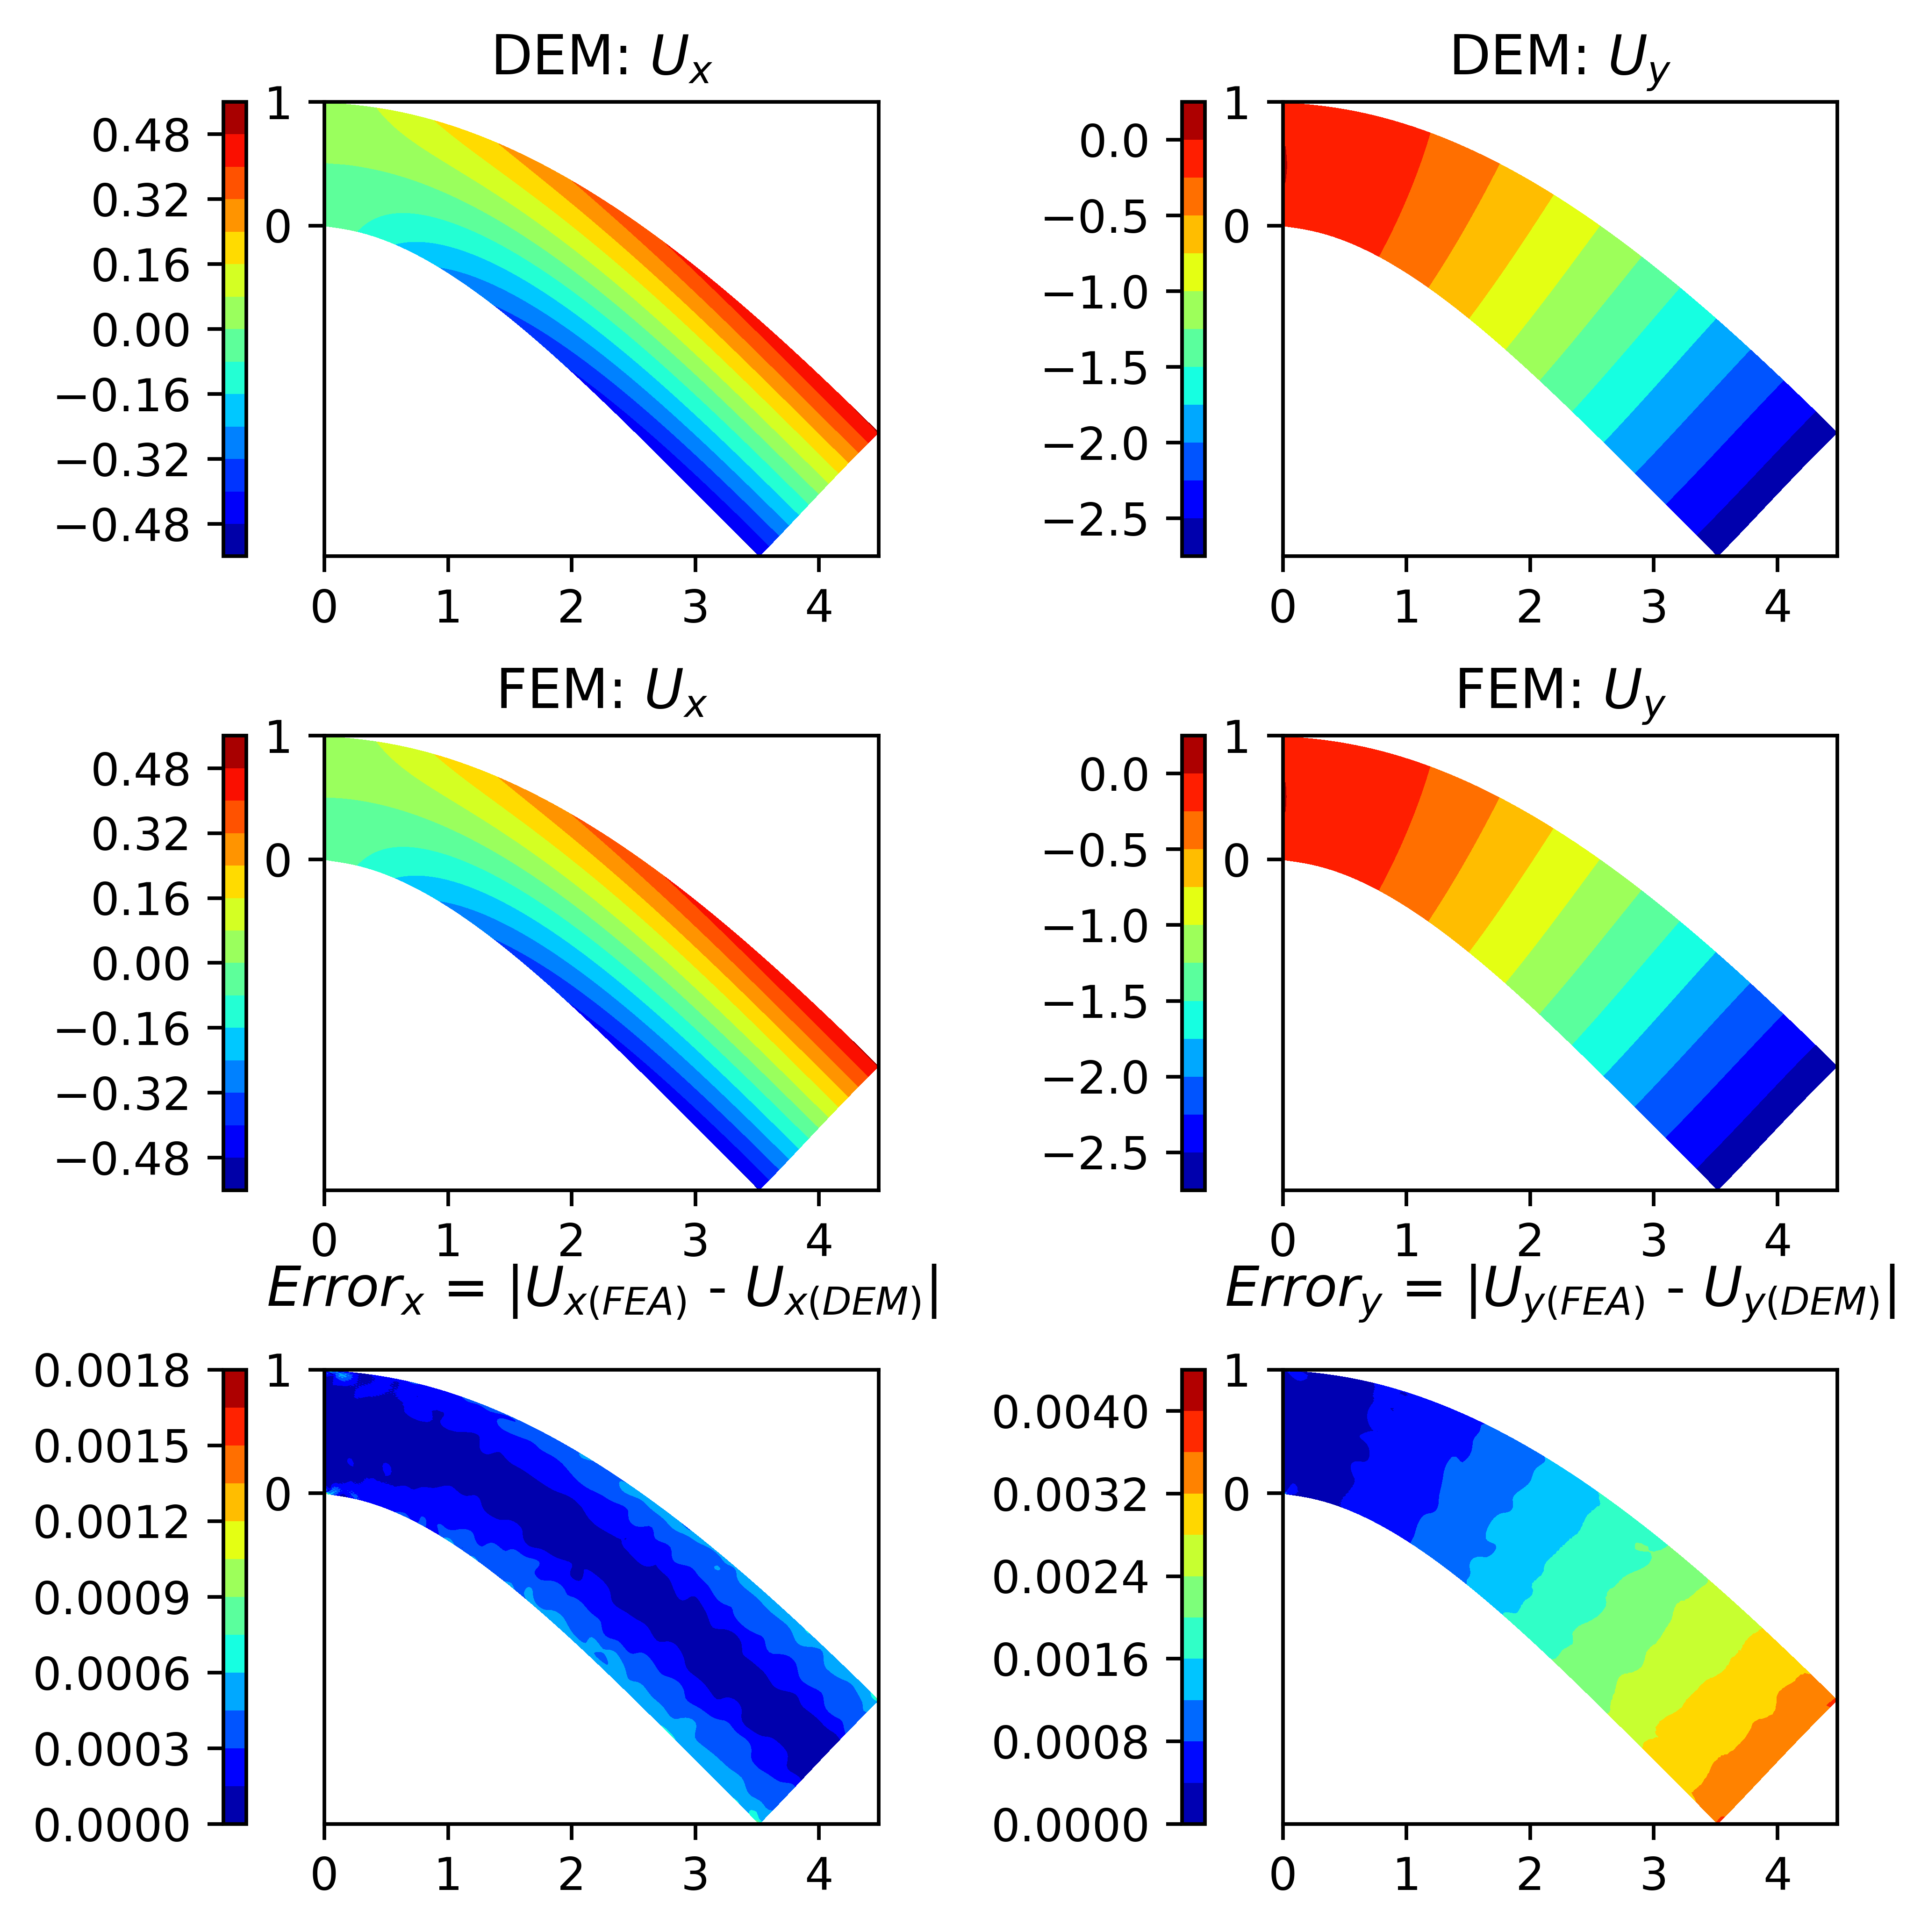

In [17]:
if __name__ == "__main__":
    main()